# Exploratory Data Analysis (EDA) 

In [1]:
# Install necessary packages 
# TO DO: fix requirements.txt file later 
#!pip install missingno
#!pip install wordcloud

In [2]:
# Import third-party libraries
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict

# Activate autoreload for custom modules
%load_ext autoreload
%autoreload 2

# Display plots inline
%matplotlib inline

# File path definitions
DATA_PATH = 'output/indeed_jobs_'

# Import local custom modules
import utils.my_functions as mf
import utils.dictionaries as dicts

# Constants and configurations

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emmafrid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data
Import the data scraped using scraper-countries.py (Sept 20-21 2024), for the following countries: USA, Sweden, France, and Italy. These datasets contain the job listings for the 3 largest cities in respective country, for the job titles _Data Scientist_, _Data Analyst_, _Product Analyst_, and _BI Analyst_.

In [3]:
# Import csv files with scraped data for resp. country 
countries = ['Sweden', 'France', 'Italy']
dfs = {country: pd.read_csv(f"{DATA_PATH}{country}.csv") for country in countries}

# Access individual dataframes as dataframes['Sweden'], dataframes['France'], etc.
df_SWE = dfs['Sweden'] 
df_FRA = dfs['France'] 
df_ITA = dfs['Italy'] 

# USA 
df_USA = mf.merge_US_cities(['NY', 'LA', 'CHI'], DATA_PATH)

Loaded data for NY
Column order for consistency: ['page', 'country', 'job_link', 'search_keyword', 'search_location', 'job_title', 'company_name', 'company_location', 'salary', 'job_description']


## Initial data inspection

In [4]:
df_SWE.head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data+Analyst,Stockholm,Data Analyst (Data Visualization),Swedium Global Services,Distansjobb in Stockholm,Not available,Data Analyst (Data Visualization) \n \n Swediu...
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data+Analyst,Stockholm,Data Analyst,Deploja AB,169 73 Solna,Not available,Role: \n \n Website Performance: Web analyst f...
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data+Analyst,Stockholm,Data Analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities \n \n Website Performance: W...
3,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data+Analyst,Stockholm,Data Analyst,Sobi,Stockholm,Heltid,Company Description \n Statistics show that w...
4,1,Sweden,https://se.indeed.com/rc/clk?jk=65bfa8c313624f...,Data+Analyst,Stockholm,"Juniora Analysts till Operations, Engineering,...",Deloitte,113 57 Stockholm,Heltid,Företagsbeskrivning \n \n \n Deloitte är en g...


In [5]:
df_FRA.head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,France,https://www.indeed.fr/rc/clk?jk=3163cc1d8a51ee...,Data+Analyst,Paris (75),CDI - Data analyst KYC - Senior F/H,La Banque Postale,Paris (75),CDI,INTRODUCTION \n Au sein de la direction Data ...
1,1,France,https://www.indeed.fr/rc/clk?jk=71fa252714d41c...,Data+Analyst,Paris (75),Data Analyst F/H,IZI Solutions Durables,Télétravail partiel à La Défense (92),CDI,"À propos \n \n En 2019, le Groupe EDF veut re..."
2,1,France,https://www.indeed.fr/rc/clk?jk=21f25c16a32522...,Data+Analyst,Paris (75),Data analyst,Le Groupe La Poste,Issy-les-Moulineaux (92),CDI,"La Poste Groupe change, nos métiers évoluent. ..."
3,1,France,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,Paris (75),Data Analyst H/F,GROUPE ID SEARCH,Paris (75),"À partir de 35 000 € par an - CDI, Temps plein","Tertialis, société du groupe ID SEARCH, est sp..."
4,1,France,https://www.indeed.fr/rc/clk?jk=8c5cc311877c09...,Data+Analyst,Paris (75),Consultant Débutant Data Analyst en CDI - Pari...,EY,92037 La Défense,CDI,Participer à la digitalisation de nos clients ...


In [6]:
df_ITA.head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Business Intelligence (Power BI) - Python- Bus...,Area IT Group,"Roma, Lazio",25.000 € - 40.000 € all'anno,Ricerchiamo Sviluppatori in almeno uno dei seg...
1,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Power Bi Analyst,Verisure Italy,00144 Roma,Not available,Ti piacerebbe far parte della multinazionale d...
2,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",IT Project Management Internship,Procter & Gamble,"Roma, Lazio",Not available,Job Location Rome Job Description INFORMATI...
3,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Credit & Collection Data Analyst,Verisure Italy S R L,00144 Roma,Not available,Ti piacerebbe far parte della multinazionale d...
4,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Aeronautical System Analyst,adecco,"Roma, Lazio",Not available,Per azienda leader a livello globale nella ges...


In [7]:
df_USA.head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,USA,https://www.indeed.com/rc/clk?jk=5bf7eb172149d...,Data+Analyst,"New+York, NY",Business Analyst (Data products),Aon,"Remote in New York, NY","$80,000 - $95,000 a year - Full-time","Senior Associate Consultant, Data Solutions ..."
1,1,USA,https://www.indeed.com/rc/clk?jk=6b99bd10f1316...,Data+Analyst,"New+York, NY",Data Analyst,NYU Langone,"New York, NY",$32.38 - $39.01 an hour - Temporary,NYU Grossman School of Medicine is one of the...
2,1,USA,https://www.indeed.com/rc/clk?jk=d70c515431fa2...,Data+Analyst,"New+York, NY",Data Analyst,NYU Langone Health,"New York, NY 10016","$67,771.14 - $75,000.00 a year - Full-time",NYU Grossman School of Medicine is one of the...
3,1,USA,https://www.indeed.com/rc/clk?jk=3aa26222eadd6...,Data+Analyst,"New+York, NY","Resy Marketing Data Analyst, Data and Analytics",Amex,"Hybrid work in New York, NY","$60,000 - $110,000 a year",You Lead the Way. We’ve Got Your Back. \n With...
4,1,USA,https://www.indeed.com/rc/clk?jk=3aa564ce173c8...,Data+Analyst,"New+York, NY",2025 University Graduate - Digital Strategy An...,Adobe,"New York, NY 10012","$53,900 - $101,450 a year - Full-time",Our Company Changing the world through digit...


### Check dimensions and data types

In [8]:
# Check dimensions of dfs 
print(f'SWE \t   columns: {df_SWE.shape[1]} \t  rows: {df_SWE.shape[0]}')
print(f'FRA \t   columns: {df_FRA.shape[1]} \t  rows: {df_FRA.shape[0]}')
print(f'ITA \t   columns: {df_ITA.shape[1]} \t  rows: {df_ITA.shape[0]}')
print(f'USA \t   columns: {df_USA.shape[1]} \t  rows: {df_USA.shape[0]}')

SWE 	   columns: 10 	  rows: 320
FRA 	   columns: 10 	  rows: 2200
ITA 	   columns: 10 	  rows: 769
USA 	   columns: 10 	  rows: 1317


In [9]:
# Check data types
df_SWE.info() 
# Most columns are of type 'Dtype object'
# Convert columns with strings only to string data type to optimize performance
# Mixed columns with both numbers and strings (keep as object): company_location, salary, job_link (url)
# Convert search_keyword to category 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   page              320 non-null    int64 
 1   country           320 non-null    object
 2   job_link          320 non-null    object
 3   search_keyword    320 non-null    object
 4   search_location   320 non-null    object
 5   job_title         320 non-null    object
 6   company_name      320 non-null    object
 7   company_location  320 non-null    object
 8   salary            320 non-null    object
 9   job_description   320 non-null    object
dtypes: int64(1), object(9)
memory usage: 25.1+ KB


In [10]:
dicts.dtype_dict

{'page': 'int64',
 'country': 'string',
 'job_link': 'object',
 'search_keyword': 'category',
 'search_location': 'string',
 'job_title': 'string',
 'company_name': 'string',
 'company_location': 'object',
 'salary': 'object',
 'job_description': 'string'}

In [11]:
# Convert columns to the correct data types 
df_SWE = df_SWE.astype(dicts.dtype_dict)
print(df_SWE.dtypes)

page                         int64
country             string[python]
job_link                    object
search_keyword            category
search_location     string[python]
job_title           string[python]
company_name        string[python]
company_location            object
salary                      object
job_description     string[python]
dtype: object


In [12]:
# Do the same for the other datasets 
df_FRA = df_FRA.astype(dicts.dtype_dict)
df_ITA = df_ITA.astype(dicts.dtype_dict)
df_USA = df_USA.astype(dicts.dtype_dict)

In [13]:
# Do this later, and make sure it works with the code below 
#df_SWE['search_keyword'] = df_SWE['search_keyword'].astype('category')
#df_SWE['search_keyword'].cat.categories
df_SWE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   page              320 non-null    int64   
 1   country           320 non-null    string  
 2   job_link          320 non-null    object  
 3   search_keyword    320 non-null    category
 4   search_location   320 non-null    string  
 5   job_title         320 non-null    string  
 6   company_name      320 non-null    string  
 7   company_location  320 non-null    object  
 8   salary            320 non-null    object  
 9   job_description   320 non-null    string  
dtypes: category(1), int64(1), object(3), string(5)
memory usage: 23.1+ KB


### Conclusions
- The following columns needs to be cleaned: search_keyword, job_title, job_description, company_location.   
- The salary column should be split into two columns (separate numeric vs string content).    

## Data Quality Assessment
Data reduction and data cleadf['column_name'] = df['column_name'].astype('category')
ning
Handle missing and duplicate data entries. Remove unnecessary columns (if any). 
Clean and preprocess the data to handle anomalies and outliers. 


- Checking for missing values
- Identifying duplicates
- Outlier detection and analysis

### Missing values

In [14]:
# The scraper labels cells as 'Not available' when there is no value. Change these to NaN. 
df_SWE.replace('Not available', np.NaN, inplace=True)
df_FRA.replace('Not available', np.NaN, inplace=True) 
df_ITA.replace('Not available', np.NaN, inplace=True)
df_USA.replace('Not available', np.NaN, inplace=True)

df_FRA.isnull().sum() # Missing salary and job description entries 
df_SWE.isnull().sum() # Missing salary entries 
df_ITA.isnull().sum() # Missing salary entries 
df_USA.isnull().sum() # Missing salary entries 

# Calculate percentage of missing values
df_FRA.isnull().mean() * 100

# Salary entries will be examined later when columns are split 
# For now we do not drop these rows (we are not primarily interested in salaries)

page                 0.000000
country              0.000000
job_link             0.000000
search_keyword       0.000000
search_location      0.000000
job_title            0.000000
company_name         0.000000
company_location     0.000000
salary              17.181818
job_description      2.318182
dtype: float64

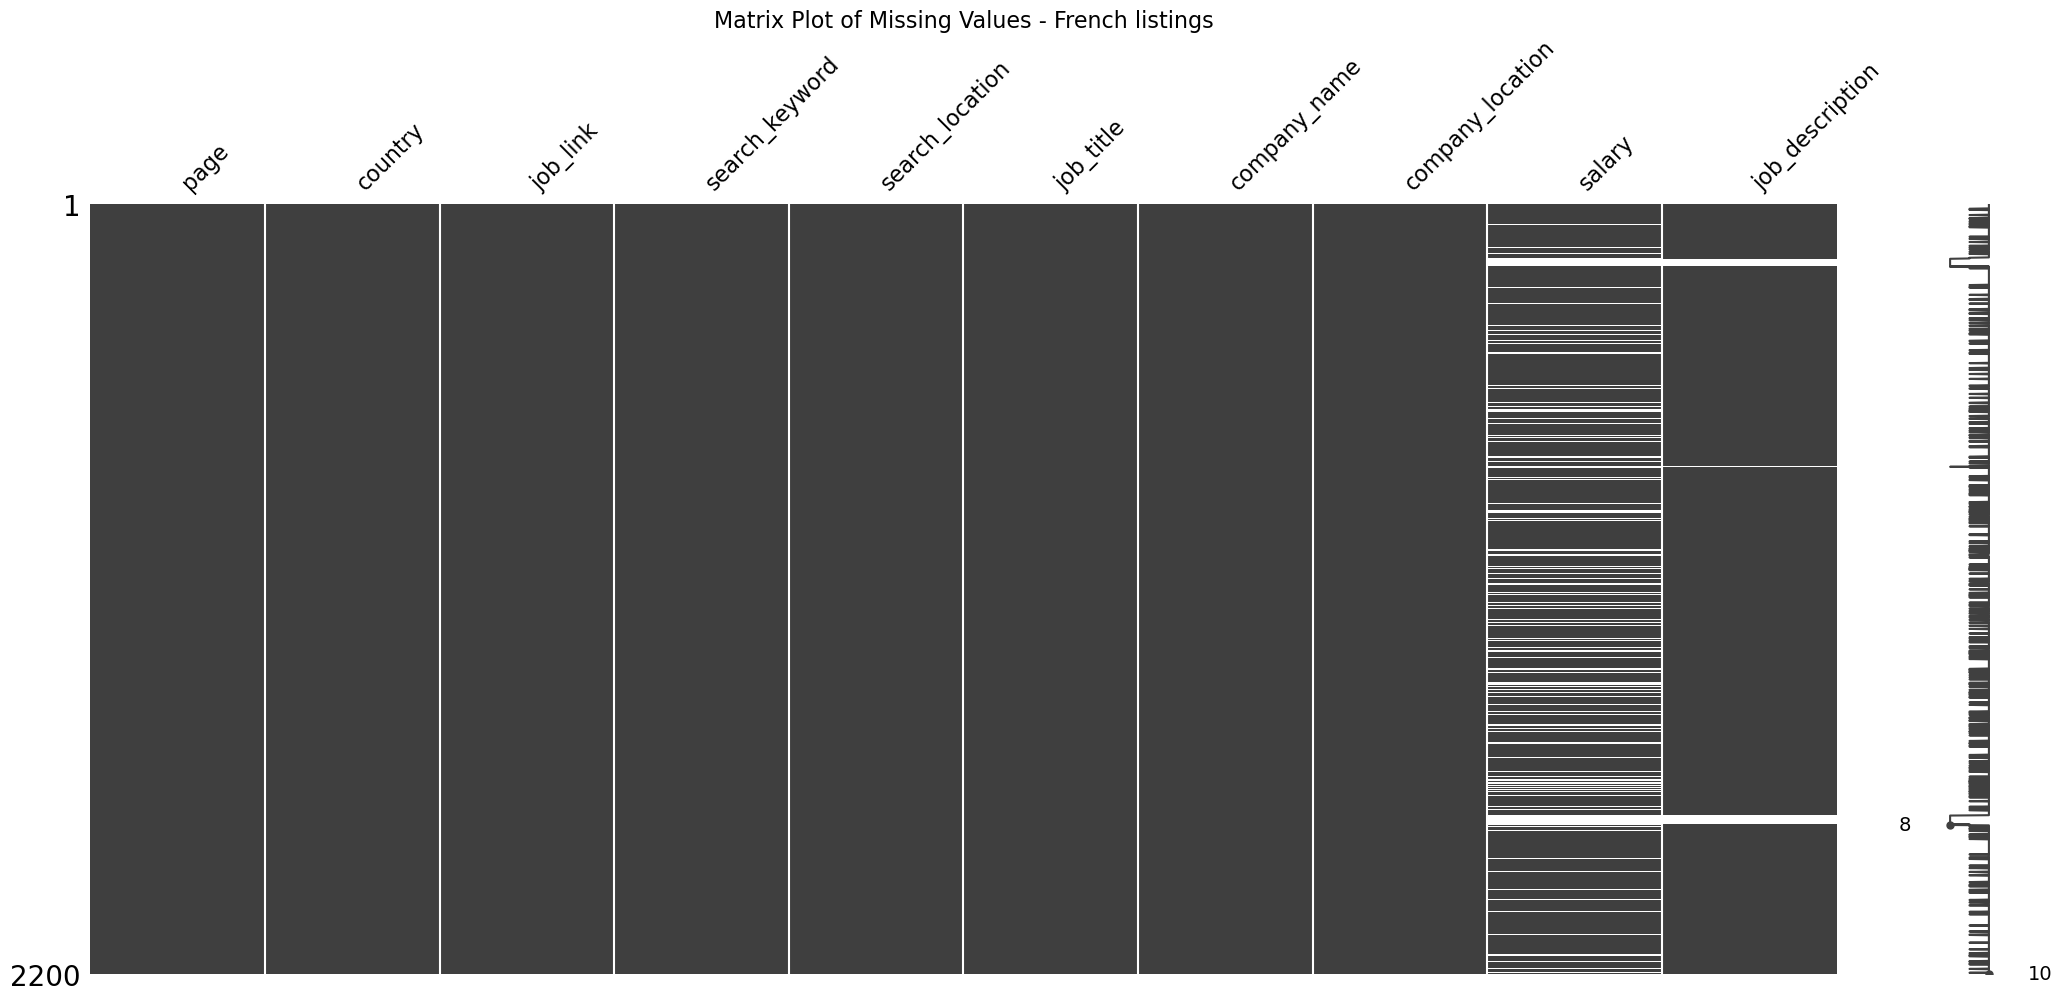

In [15]:
# Visualize missing data patterns using missingno
msno.matrix(df_FRA) #.sample(250)
plt.title('Matrix Plot of Missing Values - French listings', fontsize=16)  # Add a title to the plot
plt.show()

In [16]:
# Look into the missing descriptions for French job listings (seems that requests were blocked here?)
print(df_FRA.isnull().sum())
#df_FRA[df_FRA['job_description'].isnull()]

# Manual imports of missing job descriptions from URLs 
df_FRA_missing = pd.read_csv('df_FRA_missing_data.csv')

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description      51
dtype: int64


In [17]:
# Merge the DataFrames based on the 'job_link' column
merged_df = pd.merge(df_FRA, df_FRA_missing, on=['job_link'])
merged_df = pd.merge(df_FRA, df_FRA_missing[['job_link', 'job_description_new']], on='job_link', how='left')
# Save the job description as only one column (based on when it is not NaN)
merged_df['job_description'] = merged_df['job_description'].combine_first(merged_df['job_description_new'])
merged_df.drop('job_description_new', axis=1, inplace=True)
# Verify that there are no missing values in job_description now
merged_df.head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,France,https://www.indeed.fr/rc/clk?jk=3163cc1d8a51ee...,Data+Analyst,Paris (75),CDI - Data analyst KYC - Senior F/H,La Banque Postale,Paris (75),CDI,INTRODUCTION \n Au sein de la direction Data ...
1,1,France,https://www.indeed.fr/rc/clk?jk=71fa252714d41c...,Data+Analyst,Paris (75),Data Analyst F/H,IZI Solutions Durables,Télétravail partiel à La Défense (92),CDI,"À propos \n \n En 2019, le Groupe EDF veut re..."
2,1,France,https://www.indeed.fr/rc/clk?jk=21f25c16a32522...,Data+Analyst,Paris (75),Data analyst,Le Groupe La Poste,Issy-les-Moulineaux (92),CDI,"La Poste Groupe change, nos métiers évoluent. ..."
3,1,France,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,Paris (75),Data Analyst H/F,GROUPE ID SEARCH,Paris (75),"À partir de 35 000 € par an - CDI, Temps plein","Tertialis, société du groupe ID SEARCH, est sp..."
4,1,France,https://www.indeed.fr/rc/clk?jk=8c5cc311877c09...,Data+Analyst,Paris (75),Consultant Débutant Data Analyst en CDI - Pari...,EY,92037 La Défense,CDI,Participer à la digitalisation de nos clients ...


In [18]:
merged_df.isnull().sum()
df_FRA = merged_df
print(df_FRA.isnull().sum())

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description       0
dtype: int64


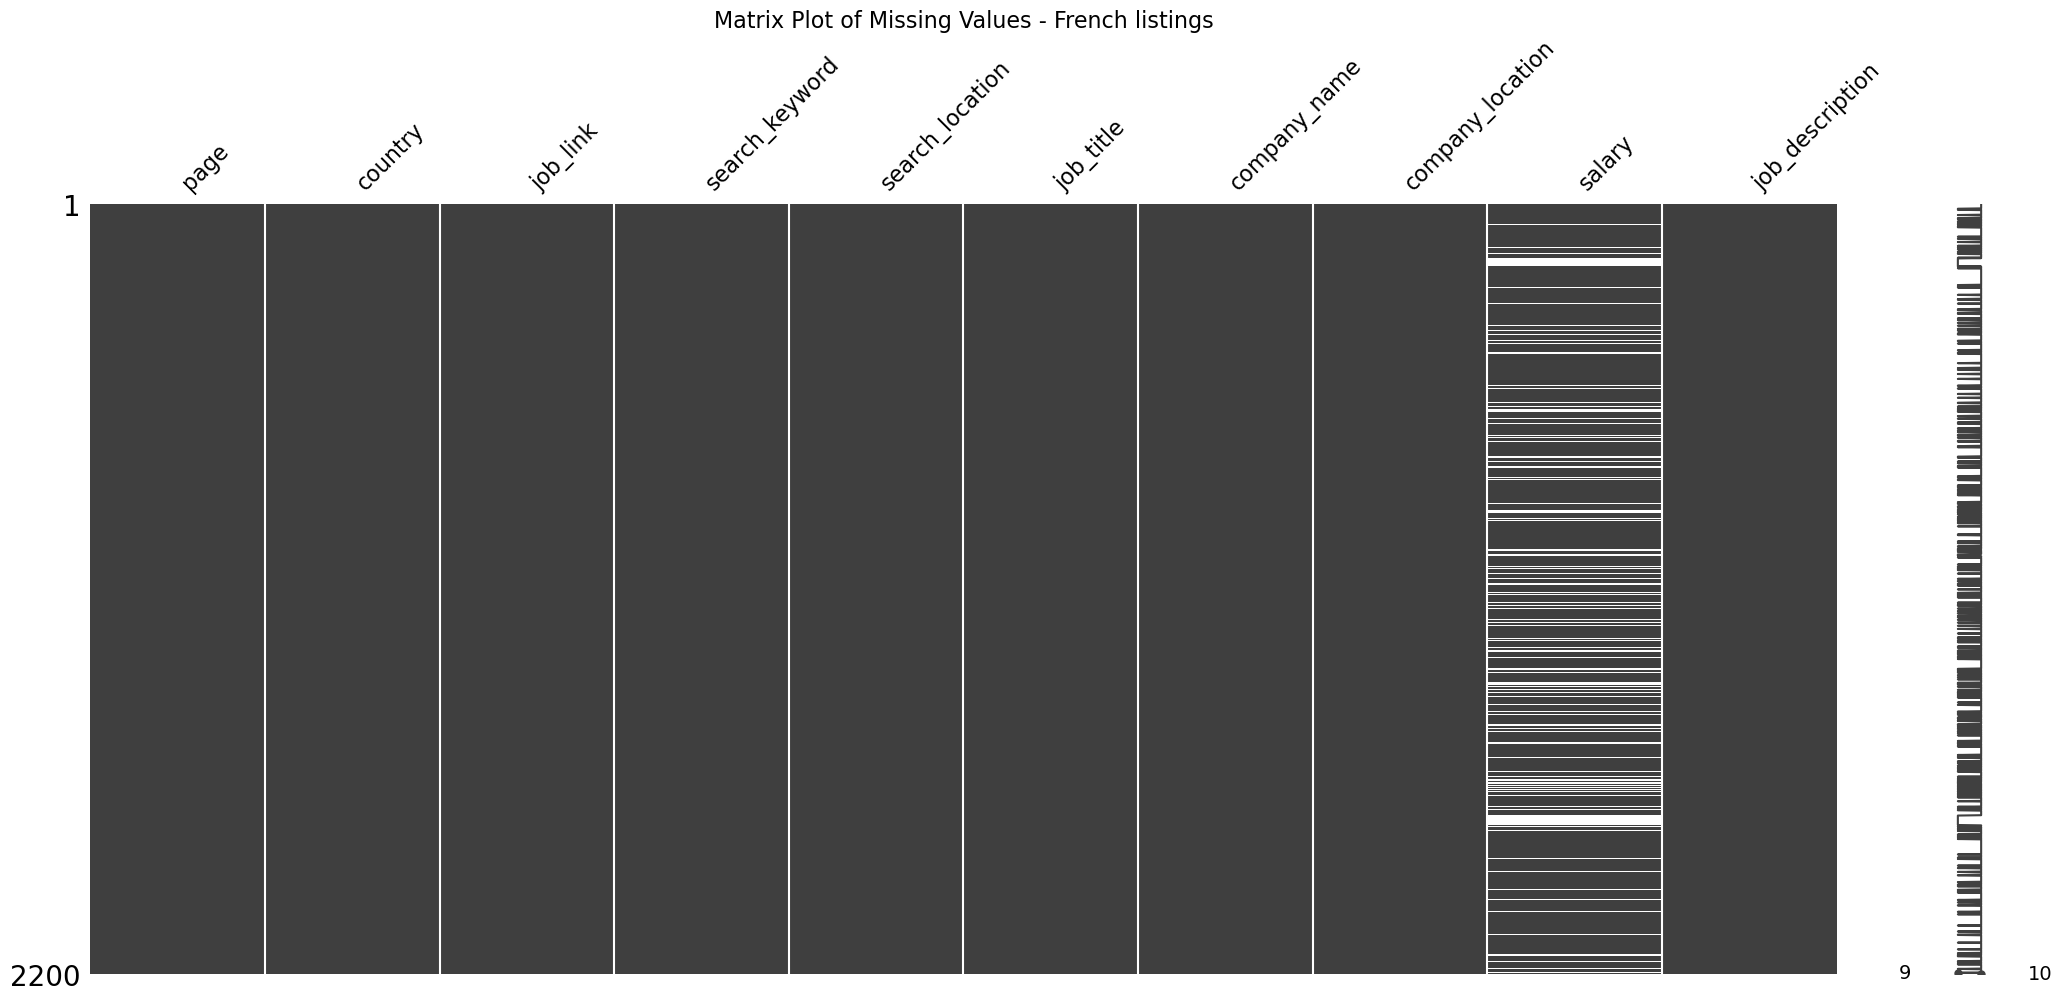

In [19]:
# Now the job_description should not have missing values anymore
msno.matrix(df_FRA) #.sample(250)
plt.title('Matrix Plot of Missing Values - French listings', fontsize=16)  
plt.show()

In [20]:
# Make sure all data types are the same after adding info from CSV
df_FRA = df_FRA.astype(dicts.dtype_dict)
print(df_FRA.dtypes)

page                         int64
country             string[python]
job_link                    object
search_keyword            category
search_location     string[python]
job_title           string[python]
company_name        string[python]
company_location            object
salary                      object
job_description     string[python]
dtype: object


In [21]:
# There are still many missing values for salary, but this is since that information was not always provided in the job listings
#df_FRA[df_FRA['salary'].isnull()]
df_FRA.isnull().sum()

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description       0
dtype: int64

### Check for duplicates

In [22]:
# Check for potential duplicates 
mf.check_duplicates(df_FRA)
mf.check_duplicates(df_SWE)
mf.check_duplicates(df_ITA)
mf.check_duplicates(df_USA)

The DataFrame has 2200 rows.
page                  47
country                1
job_link            2200
search_keyword         4
search_location        3
job_title           1213
company_name         718
company_location     256
salary               164
job_description     1355
dtype: int64
Empty DataFrame
Columns: [page, country, job_link, search_keyword, search_location, job_title, company_name, company_location, salary, job_description]
Index: []
The DataFrame has 320 rows.
page                  7
country               1
job_link            320
search_keyword        4
search_location       3
job_title           198
company_name        198
company_location     88
salary               10
job_description     263
dtype: int64
Empty DataFrame
Columns: [page, country, job_link, search_keyword, search_location, job_title, company_name, company_location, salary, job_description]
Index: []
The DataFrame has 769 rows.
page                 20
country               1
job_link            769
sea

No rows are completely identical, but perhaps there are <i>job descriptions</i> that are identical? 

In [23]:
# Identify duplicates (same job title, location, and job description, and keep only the latest job listing(
df_SWE = mf.remove_duplicates_jobdesc(df_SWE) 
df_FRA = mf.remove_duplicates_jobdesc(df_FRA) 
df_ITA = mf.remove_duplicates_jobdesc(df_ITA)
df_USA = mf.remove_duplicates_jobdesc(df_USA) 

There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 3200 Size after removing duplicates: 2630
There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 22000 Size after removing duplicates: 13650
There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 7690 Size after removing duplicates: 5690
There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 13170 Size after removing duplicates: 8350


There are numerous examples of when job descriptions are completely identical. These are likely reposts (the same job appearing multiple times, just with different unique links!). 
<b>Remove these entries if the job titles are the same and the locations are the same.</b> 

## Descriptive statistics

In [24]:
# Describe (numerical) columns  
df_SWE.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,263.000000,263,263,263,263,263,263,263,113,263
unique,NaN,1,263,4,3,198,198,88,10,263
top,NaN,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data+Scientist,Stockholm,Systemutvecklare,Cubane Solutions AB,Stockholm,Heltid,Company Description \n Statistics show that w...
freq,NaN,263,1,131,186,19,7,69,58,1
mean,2.593156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.789993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Clean job_title column 
df_FRA['job_title'] = df_FRA['job_title'].str.lower().str.replace(r'\(?(h/f|f/h)\)?', '', regex=True).str.strip()
df_USA['job_title'] = df_USA['job_title'].str.lower()
df_ITA['job_title'] = df_ITA['job_title'].str.lower()
df_SWE['job_title'] = df_SWE['job_title'].str.lower()

In [26]:
# Describe categorical columns  
mf.desc_categorical(df_SWE) 

Value counts for column: country
country
Sweden    263
Name: count, dtype: Int64

Value counts for column: search_location
search_location
Stockholm    186
Göteborg      54
Malmö         23
Name: count, dtype: Int64

Value counts for column: job_title
job_title
systemutvecklare                                 19
data scientist                                   13
data analyst                                     13
business analyst                                  8
senior data scientist                             5
                                                 ..
senior logistics analyst                          1
powerbi utvecklare                                1
data analyst inom produktion                      1
web analyst to axel johnson international         1
production analytics lead [game intelligence]     1
Name: count, Length: 194, dtype: Int64

Value counts for column: company_name
company_name
Cubane Solutions AB                                 7
Deploja AB           

### Preliminary observations, Swedish job listings:
- __Most frequent job titles__: Systemutvecklare, Data Analyst, Data Scientist.
- __Most frequent company__: Cubane Solutions AB. 
- __Company location__: Stockholm primarily. 
- __Salary ranges__: Few numerical values are provided.

In [27]:
df_FRA.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,1365.000000,1365,1365,1365,1365,1365,1365,1365,1107,1365
unique,NaN,1,1365,4,3,1153,717,256,164,1355
top,NaN,France,https://www.indeed.fr/rc/clk?jk=307bf16bdd8ce5...,Product+Analyst,Paris (75),data analyst,AXA,Paris (75),Temps plein,Line of Service Advisory \n \n Industry/Sect...
freq,NaN,1365,1,502,1198,38,37,380,300,4
mean,16.523810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,12.436244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
mf.desc_categorical(df_FRA) 

Value counts for column: country
country
France    1365
Name: count, dtype: Int64

Value counts for column: search_location
search_location
Paris (75)        1198
Lyon (69)          133
Marseille (13)      34
Name: count, dtype: Int64

Value counts for column: job_title
job_title
data analyst                                                  38
data scientist                                                32
business analyst                                              13
data analyst intern                                            8
business analyst data                                          7
                                                              ..
senior data engineer aws                                       1
senior financial data analyst | deals (m&a) | cdi |            1
vie procurement distribution & perf.                           1
senior data analyst | deals (m&a) | cdi |                      1
senior financial data analyst | deals (m&a) | lyon | cdi |     1
Name

### Preliminary observations, French job listings:
- Many listings compared to Sweden. 
- __Most frequent job titles__: Data Analyst (many similar names for this title, e.g. Data Analyst H/F and Data Analyst Intern). 
- __Most frequently mentioned company__: AXA.
- __Company location__: Most in Paris. Includes some information about télétravail (especially common in Paris).  
- __Salary ranges__: Need to split column to be able to draw any conclusions.

In [29]:
df_ITA.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,569.000000,569,569,569,569,569,569,569,18,569
unique,NaN,1,569,4,3,454,309,96,14,554
top,NaN,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Milano, Lombardia",data scientist,BIP - Business Integration Partners,"Milano, Lombardia",1.000 € al mese,"NTT DATA, Trusted Global Innovator, è tra i pr..."
freq,NaN,569,1,260,390,33,30,149,3,3
mean,5.495606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,5.095952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
mf.desc_categorical(df_ITA) 

Value counts for column: country
country
Italy    569
Name: count, dtype: Int64

Value counts for column: search_location
search_location
Milano, Lombardia    390
Roma, Lazio          159
Napoli, Campania      20
Name: count, dtype: Int64

Value counts for column: job_title
job_title
data scientist                      33
data analyst                        16
business analyst                    11
senior data analyst                  6
data engineer                        4
                                    ..
junior business analyst autohero     1
bi engineer                          1
data scientist middle                1
senior business analyst              1
crm analyst                          1
Name: count, Length: 454, dtype: Int64

Value counts for column: company_name
company_name
BIP - Business Integration Partners    30
NTT Data                               16
KPMG                                   14
DXC Technology                         11
Euronext                   

### Preliminary observations, Italian job listings:
- Many listings compared to Sweden, but less than France.
- __Most frequent job titles__: Data Analyst, Data Scientist, Business Analyst. 
- __Most frequently mentioned company__: BIP - Business Integration Partners. 
- __Company location__: Milano. Also remote in Milano is relatively common (as is Rome).
- __Salary ranges__: Very few numerical entries provided. 

In [31]:
df_USA.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,835.000000,835,835,835,835,835,835,835,789,835
unique,NaN,1,835,4,3,737,470,185,524,823
top,NaN,USA,https://www.indeed.com/rc/clk?jk=d70c515431fa2...,Data+Scientist,"New+York, NY",data analyst,Citi,"New York, NY",Full-time,A career in Products and Technology is an oppo...
freq,NaN,835,1,264,487,12,27,179,149,2
mean,6.234731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.419001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
mf.desc_categorical(df_USA) 

Value counts for column: country
country
USA    835
Name: count, dtype: Int64

Value counts for column: search_location
search_location
New+York, NY       487
Chicago, IL        264
Los+Angeles, CA     84
Name: count, dtype: Int64

Value counts for column: job_title
job_title
data analyst                                                   12
business analyst                                               11
senior machine learning engineer                                9
senior data scientist                                           8
senior business analyst                                         5
                                                               ..
sr. it business analyst, erp financial systems                  1
senior business analyst, product information                    1
senior business process analyst (application modernization)     1
analyst sap fi-co business                                      1
sr. director of data, analytics and ai                         

### Preliminary observations, American job listings:
- Number of listings are less than for France. 
- __Most frequent job titles__: Data Analyst, BI analyst, (Senior) Data Scientist. Interesting that Machine Learning Engineer shows up. Might need to cluster similar terms to get full picture (e.g. remove Senior etc.). 
- __Most frequently mentioned company__: Citi. 
- __Company location__: New York.  
- __Salary ranges__: Need to split column to draw conclusions. 

In [33]:
## 4. Univariate Analysis
# - Numerical feature distribution
# - Categorical feature distribution

## 5. Bivariate and Multivariate Analysis
# - Pairwise correlations
# - Relationships between key variables


## Feature engineering 

### Retrieve numeric values for salary

In [34]:
# Dictionary of data frames 
dfs = {'SWE': df_SWE, 'FRA': df_FRA, 'ITA': df_ITA, 'USA': df_USA}

# Loop through the dictionary and apply the function to clean dfs and add currency and salaries
dfs = {key: mf.clean_and_add_currency_and_salaries(df, dicts.currency_mapping[key]) for key, df in dfs.items()}

In [35]:

'''
# Unpack the cleaned DataFrames
df_SWE, df_FRA, df_ITA, df_USA = dfs.values()

# Inspect output 
print(df_ITA.isnull().sum())
# Check salary ranges 
df_ITA.describe()
# Filter out data when column 'salary_num' is not NaN
df_filtered = df_ITA.dropna(subset=['salary_num'])
df_filtered
'''

"\n# Unpack the cleaned DataFrames\ndf_SWE, df_FRA, df_ITA, df_USA = dfs.values()\n\n# Inspect output \nprint(df_ITA.isnull().sum())\n# Check salary ranges \ndf_ITA.describe()\n# Filter out data when column 'salary_num' is not NaN\ndf_filtered = df_ITA.dropna(subset=['salary_num'])\ndf_filtered\n"

In [36]:
# Merge all dfs in the dictionary into a single df
df_combined = pd.concat(dfs.values(), ignore_index=True)
df_combined.reset_index(drop=True, inplace=True)

# Add dates when data was scraped 
df_combined['date'] = np.where(df_combined['country'].isin(['Sweden', 'USA']), pd.to_datetime('2024-09-19'), pd.to_datetime('2024-09-20'))
df_combined.describe()

,page,salary_num_low,salary_num_high,min_salary_month,max_salary_month,date
count,3032.000000,8.200000e+02,8.200000e+02,8.200000e+02,8.200000e+02,3032
mean,10.412269,3.211484e+05,4.760533e+05,3.756959e+04,5.321188e+04,2024-09-19 15:18:31.345646592
min,1.000000,6.000000e+00,6.000000e+00,6.000000e+00,3.416667e+00,2024-09-19 00:00:00
25%,3.000000,5.000000e+04,6.500000e+04,4.900000e+03,6.412000e+03,2024-09-19 00:00:00
50%,6.000000,9.000000e+04,1.294000e+05,7.916667e+03,1.126000e+04,2024-09-20 00:00:00
75%,15.000000,1.308000e+05,2.000000e+05,1.165417e+04,1.698125e+04,2024-09-20 00:00:00
max,47.000000,1.250912e+07,2.842800e+07,1.096960e+06,2.369000e+06,2024-09-20 00:00:00
std,10.563513,1.427072e+06,2.191826e+06,1.449375e+05,2.096597e+05,NaN


In [37]:
# Get exchange rate from SEK to EUR
sek_to_eur = mf.get_exchange_rate('SEK', 'EUR')
# Get exchange rate from USD to EUR
usd_to_eur = mf.get_exchange_rate('USD', 'EUR')

print(f"The exchange rate from SEK to EUR is: {sek_to_eur}")
print(f"The exchange rate from USD to EUR is: {usd_to_eur}")

The exchange rate from SEK to EUR is: 0.08618
The exchange rate from USD to EUR is: 0.9494


In [38]:
# Convert salary to same currency using exchange rate
df_combined.loc[(df_combined['currency'] == 'SEK') & (df_combined['min_salary_month'].notna()), 'min_salary_month_EUR'] = df_combined['min_salary_month'] * sek_to_eur
df_combined.loc[(df_combined['currency'] == 'SEK') & (df_combined['max_salary_month'].notna()), 'max_salary_month_EUR'] = df_combined['max_salary_month'] * sek_to_eur

df_combined.loc[(df_combined['currency'] == 'USD') & (df_combined['min_salary_month'].notna()), 'min_salary_month_EUR'] = df_combined['min_salary_month'] * usd_to_eur
df_combined.loc[(df_combined['currency'] == 'USD') & (df_combined['max_salary_month'].notna()), 'max_salary_month_EUR'] = df_combined['max_salary_month'] * usd_to_eur

df_combined.loc[(df_combined['country'].isin(['France', 'Italy'])) & (df_combined['min_salary_month'].notna()), 'min_salary_month_EUR'] = df_combined['min_salary_month']
df_combined.loc[(df_combined['country'].isin(['France', 'Italy'])) & (df_combined['max_salary_month'].notna()), 'max_salary_month_EUR'] = df_combined['max_salary_month']

# Verify that it worked 
#df_combined[mask]

In [39]:
# Maybe good to assign a job id to a column, instead of checking for unique URLs 
df_combined.insert(0, 'job_id', range(1, len(df_combined) + 1))

In [40]:
df_combined.head(5)

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,...,salary_num,salary_num_low,salary_num_high,time_period,currency,min_salary_month,max_salary_month,date,min_salary_month_EUR,max_salary_month_EUR
0,1,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data+Analyst,Stockholm,data analyst,Sobi,Stockholm,Heltid,...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19,NaN,NaN
1,2,1,Sweden,https://se.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,Stockholm,fraud & data analyst to the fraud strategy & a...,Entercard Group AB,111 39 Stockholm,nan,...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19,NaN,NaN
2,3,1,Sweden,https://se.indeed.com/rc/clk?jk=27fb82edf82fcd...,Data+Analyst,Stockholm,data analyst,Star Stable Entertainment,Distansjobb in 118 27 Stockholm,nan,...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19,NaN,NaN
3,4,1,Sweden,https://se.indeed.com/rc/clk?jk=7fa39868401ee6...,Data+Analyst,Stockholm,data analyst,Baby Journey AB,114 51 Stockholm,nan,...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19,NaN,NaN
4,5,2,Sweden,https://se.indeed.com/rc/clk?jk=e8928767cb355b...,Data+Analyst,Stockholm,oit-237 data classification and labeling analyst,WSP Sverige,111 20 Stockholm,nan,...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19,NaN,NaN


### Detect keywords 

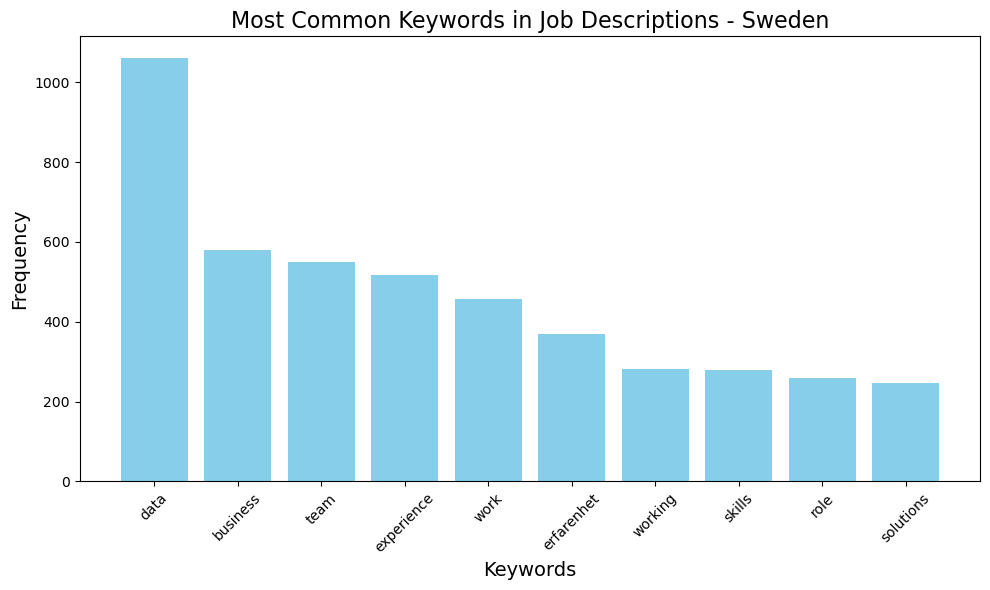

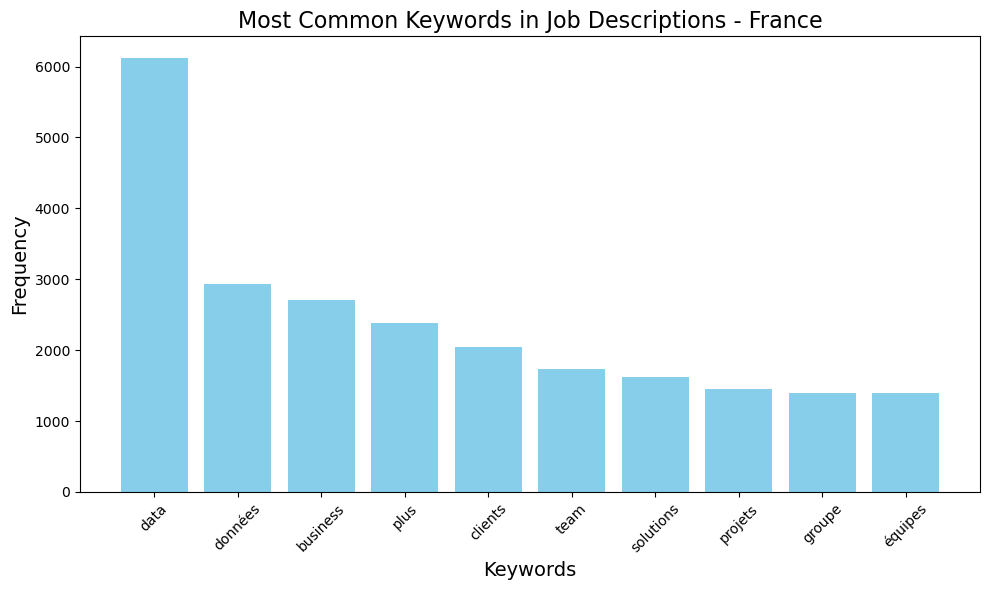

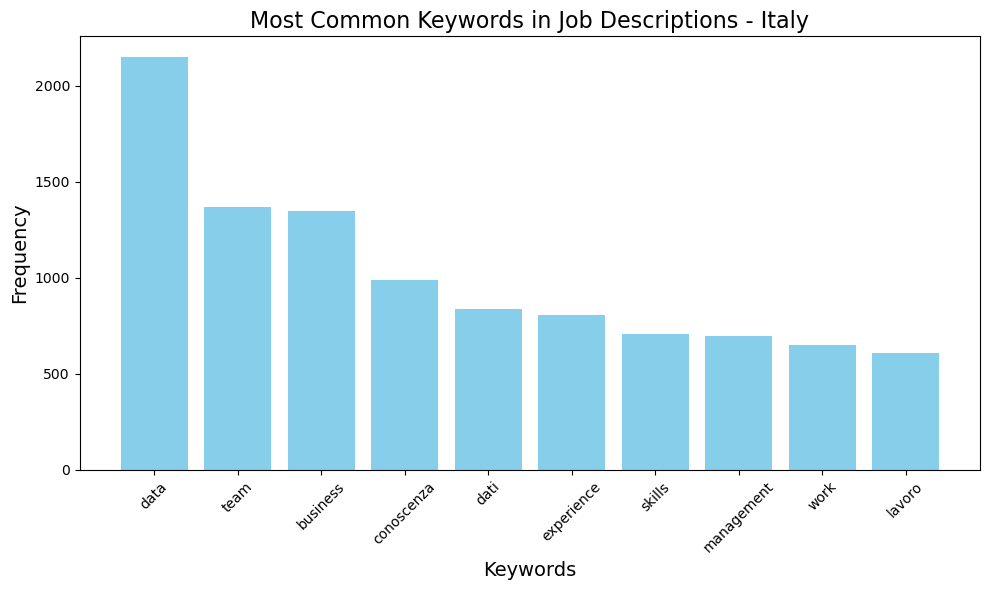

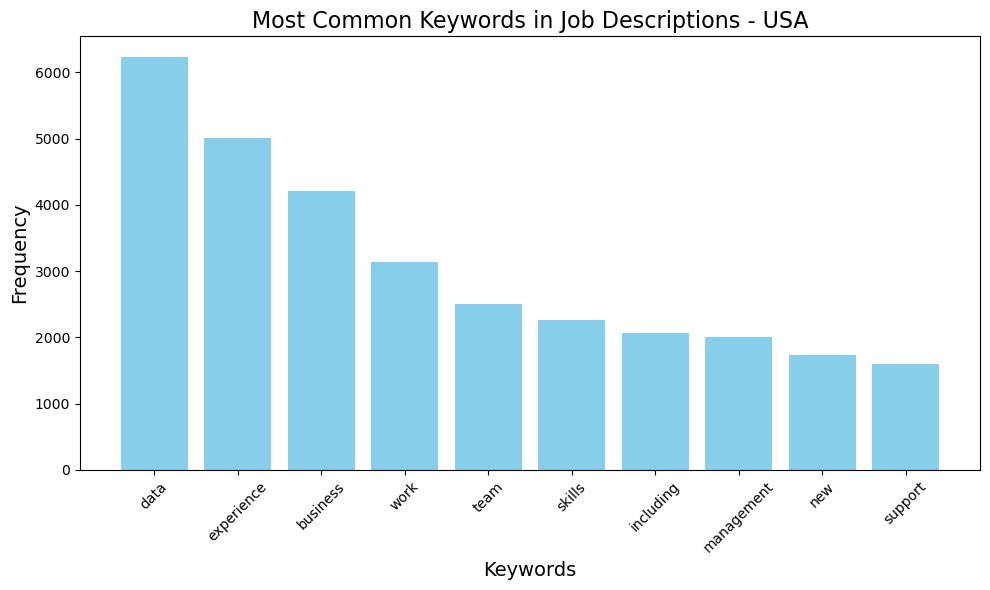

In [41]:
# Extract keywords 
common_keywords_SWE = mf.extract_keywords(df_combined, 'Sweden', 'swedish')
common_keywords_FRA = mf.extract_keywords(df_combined, 'France', 'french')
common_keywords_ITA = mf.extract_keywords(df_combined, 'Italy', 'italian')
common_keywords_USA = mf.extract_keywords(df_combined, 'USA', 'english')

# Plot common keywords 
mf.plot_common_keywords(common_keywords_SWE[0], 'Sweden')
mf.plot_common_keywords(common_keywords_FRA[0], 'France')
mf.plot_common_keywords(common_keywords_ITA[0], 'Italy')
mf.plot_common_keywords(common_keywords_USA[0], 'USA')

In [42]:
# Calculate software/programming keyword counts for each country 
keyword_counts_SWE = mf.count_keywords(df_combined, 'Sweden', dicts.software_keywords)
keyword_counts_FRA = mf.count_keywords(df_combined, 'France', dicts.software_keywords)
keyword_counts_ITA = mf.count_keywords(df_combined, 'Italy', dicts.software_keywords)
keyword_counts_USA = mf.count_keywords(df_combined, 'USA', dicts.software_keywords)

# Combine all dfs into one
keyword_counts_combined = pd.concat([keyword_counts_SWE, keyword_counts_FRA, keyword_counts_ITA, keyword_counts_USA], ignore_index=True)
keyword_counts_combined.sort_values(by=['Count'], ascending=[False])

,Category,Keyword,Search Keyword,Country,Count
333,Development Tools,git,Product+Analyst,France,524
230,Data Analysis and Manipulation,excel,Product+Analyst,France,461
275,Data Visualization and Business Intelligence (...,power bi,BI+Analyst,France,357
331,Development Tools,git,Data+Analyst,France,349
724,Data Analysis and Manipulation,excel,BI+Analyst,USA,342
...,...,...,...,...,...
85,Development Tools,atom,Data+Scientist,Sweden,1
523,Data Visualization and Business Intelligence (...,looker studio,Data+Analyst,Italy,1
755,Data Visualization and Business Intelligence (...,looker studio,BI+Analyst,USA,1
519,Data Visualization and Business Intelligence (...,looker,BI+Analyst,Italy,1


In [43]:
# Extract interview information
interview_info_df, interview_flags_df = mf.extract_interview_details(df_combined)

In [44]:
# Sum only Boolean columns in interview_flags_df to count occurrences of each stage
stage_counts = interview_flags_df.select_dtypes(include='bool').sum()
stage_counts

phone_screening          6
technical_screening      7
case_study              16
coding_assessment        6
behavioral_interview     4
on_site_interview        2
presentation             0
dtype: int64

In [45]:
filtered_df = interview_info_df[interview_info_df['case_study_text'].notna()]
filtered_df.head()

,job_id,job_title,job_link,phone_screening_text,technical_screening_text,case_study_text,coding_assessment_text,behavioral_interview_text,on_site_interview_text,presentation_text
284,285,transversal business analyst - internship - pa...,https://www.indeed.fr/rc/clk?jk=6005a985b0c4c2...,None,None,ition team. Excel case study. Final interv...,None,None,None,None
775,776,strategy & operations intern,https://www.indeed.fr/rc/clk?jk=b734e01506d4df...,ion form on Lever Screening call with curren...,None,Mission-specific case study with our Head of S...,None,None,None,None
787,788,data analyst - product strategy (m/f/x),https://www.indeed.fr/rc/clk?jk=fe2845dfc269a5...,None,None,you to carry out a case study and meet your li...,None,None,None,None
822,823,data analyst (internship),https://www.indeed.fr/rc/clk?jk=97e4f13fbdafbf...,None,None,epare and present a case study to both Joshua ...,None,None,None,None
873,874,supply and forecast analyst - fixed-term contr...,https://www.indeed.fr/rc/clk?jk=810703d4ec1e96...,None,None,about Bene Bono. Case study here! Do your be...,None,None,None,None


In [46]:
'''
# Specify the job IDs you want to compare
job_id_1 = 2581
job_id_2 = 2714

# Filter the rows for these specific job IDs and select the column
description_1 = df_combined.loc[df_combined['job_id'] == job_id_1, 'job_description'].values[0]
description_2 = df_combined.loc[df_combined['job_id'] == job_id_2, 'job_description'].values[0]

# Compare the two values
if description_1 == description_2:
    print(f"The job descriptions for job IDs {job_id_1} and {job_id_2} are the same.")
else:
    print(f"The job descriptions for job IDs {job_id_1} and {job_id_2} are different.")
'''

'\n# Specify the job IDs you want to compare\njob_id_1 = 2581\njob_id_2 = 2714\n\n# Filter the rows for these specific job IDs and select the column\ndescription_1 = df_combined.loc[df_combined[\'job_id\'] == job_id_1, \'job_description\'].values[0]\ndescription_2 = df_combined.loc[df_combined[\'job_id\'] == job_id_2, \'job_description\'].values[0]\n\n# Compare the two values\nif description_1 == description_2:\n    print(f"The job descriptions for job IDs {job_id_1} and {job_id_2} are the same.")\nelse:\n    print(f"The job descriptions for job IDs {job_id_1} and {job_id_2} are different.")\n'

Information about the interview process seems to mostly be missing/left out from the job listnings. However, the most common category appears to be stages such as case studies, followed by phone screening, technical assessments, and coding assessments.

## Univariate analysis 


In [47]:
# Categorical variables
categorical_cols = ['country', 'job_title', 'company_name', 'company_location']

# filtered_df = df_combined[df_combined['search_keyword'] == 'Data Scientist'][['country', 'search_keyword', 'job_title', 'company_name', 'company_location']]
# filtered_df['job_title'].value_counts()
# Things to fix for all job_title entries: to lower, remove (H/F) and (F/H) and H/F and F/H 


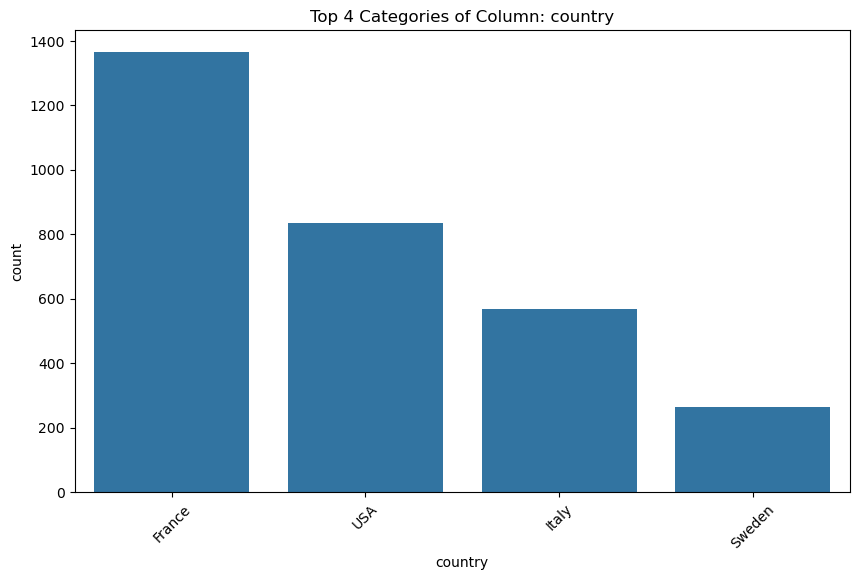

In [48]:
# Plotting frequency distribution
mf.plot_categorical(df_combined, ['country'], top_n=4, horizontal=False)

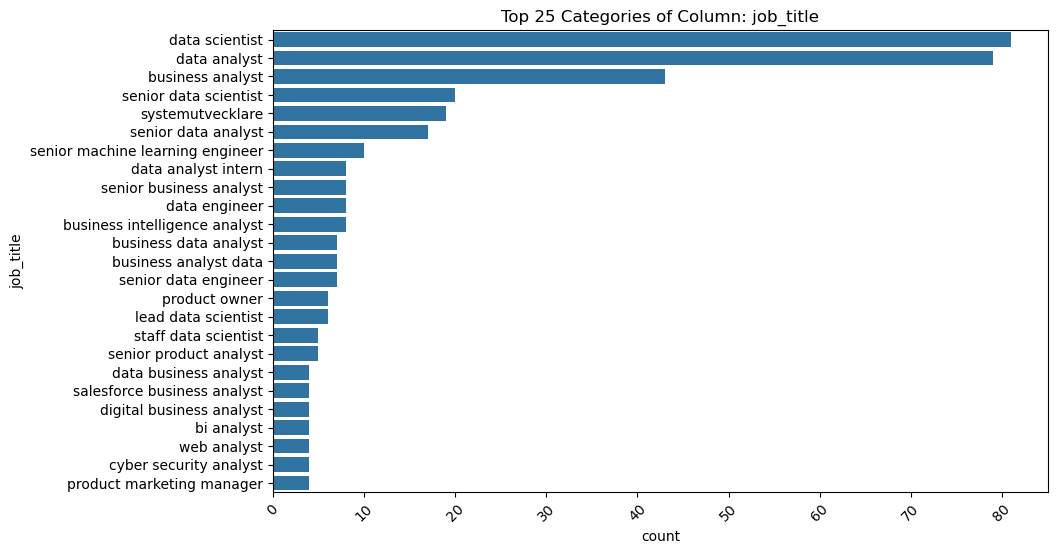

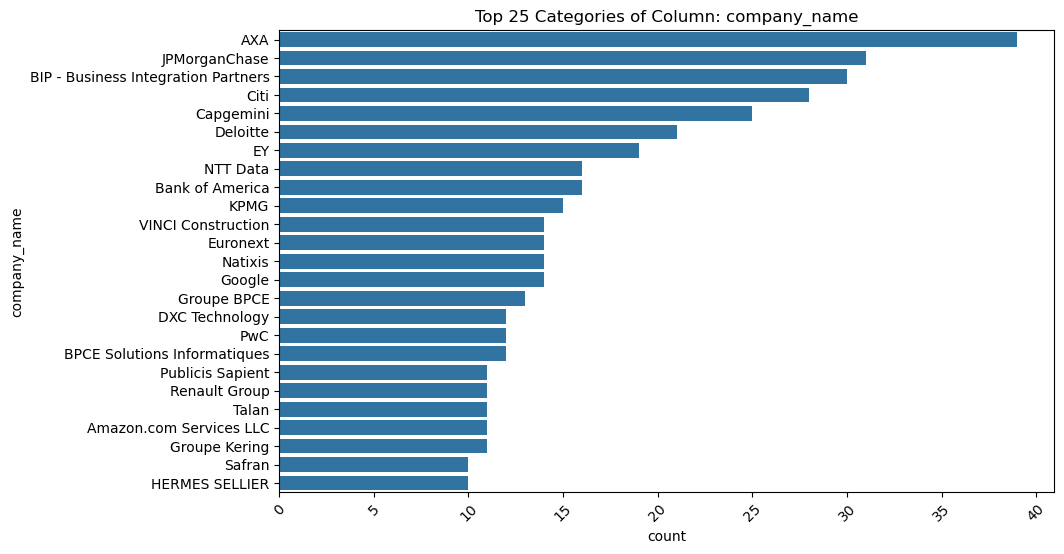

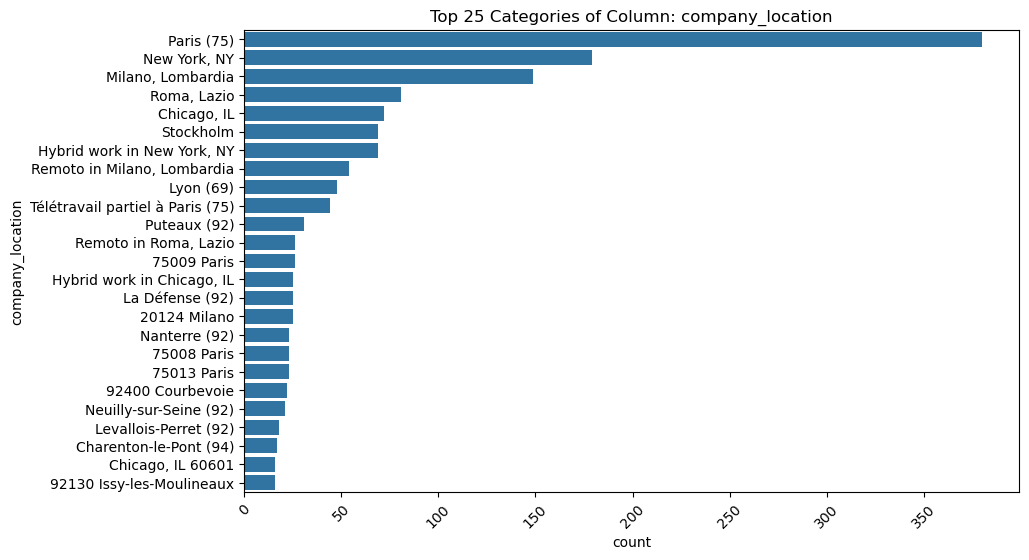

In [49]:
# Example usage
mf.plot_categorical(df_combined, ['job_title', 'company_name', 'company_location'], top_n=25, horizontal=True)
# It seems like the counts are not checking for CAPTIONS ! Need to add to lower
# Need to also group titles that are basically the same, e.g. strip (F/H) and (H/F) from french jobs 
# Same goes for Chicago, IL and so on 

Locations might need to be reformatted to fit better into map view in Tableau. 

In [50]:
# There seem to be some formatting errors for certain salaries
# For example, there is a 41 in the middle here
df_combined['salary_num'].dropna()

110             [40 000, 80 000]
221             [15 000, 20 000]
265                 [721, 1 747]
285     [38 452, 41, 50 000, 00]
290                 [800, 1 500]
                  ...           
3021            [90,000, 95,000]
3022            [60,000, 70,000]
3023     [98,490.00, 147,787.50]
3027                    [70, 80]
3030           [88,000, 120,000]
Name: salary_num, Length: 820, dtype: object

In [51]:
# Set the display options to show all rows and columns
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

df_combined[df_combined['country'] == 'USA']['salary_num'].dropna()

2197     [67,771.14, 75,000.00]
2198          [60,000, 110,000]
2199     [67,771.14, 68,900.00]
2200          [60,000, 110,000]
2201          [86,201, 103,911]
                 ...           
3021           [90,000, 95,000]
3022           [60,000, 70,000]
3023    [98,490.00, 147,787.50]
3027                   [70, 80]
3030          [88,000, 120,000]
Name: salary_num, Length: 625, dtype: object

In [52]:
#df_combined[df_combined['salary_num'].notna()]
# France 
mask_fr = df_combined['job_id'].isin([286, 323, 556, 678, 659, 673, 727, 744, 896, 768, 1094, 1142, 1288, 1317, 1350, 1456, 1469, 1477, 1478, 1481, 1483])
df_combined[mask_fr] # this doesnt work! 

# USA 
#mask_US = df_combined['job_id'].isin([2205,2207, 2220])
#df_combined[mask_US] # this actually works fine! 



,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,...,salary_num,salary_num_low,salary_num_high,time_period,currency,min_salary_month,max_salary_month,date,min_salary_month_EUR,max_salary_month_EUR
285,286,8,France,https://www.indeed.fr/rc/clk?jk=170951741428ce...,Data+Analyst,Paris (75),business data analyst,Lucky Cart,75002 Paris 2e,"De 38 452,41 € à 50 000,00 € par an - CDI, ...",...,"[38 452, 41, 50 000, 00]",38452.0,41.0,par an,EUR,3204.333333,3.416667,2024-09-20,3204.333333,3.416667
322,323,13,France,https://www.indeed.fr/rc/clk?jk=333e43478822ff...,Data+Analyst,Paris (75),développeur data analyst,Synopsia,Télétravail partiel à 75002 Paris 2e,"De 35 114,48 € à 45 000,00 € par an - CDI, ...",...,"[35 114, 48, 45 000, 00]",35114.0,48.0,par an,EUR,2926.166667,4.000000,2024-09-20,2926.166667,4.000000
555,556,1,France,https://www.indeed.fr/rc/clk?jk=c7df1a78ee680f...,Data+Scientist,Paris (75),alternant data scientist,Kaischool,Télétravail à 94120 Fontenay-sous-Bois,"De 32 745,96 € à 57 836,50 € par an - Alter...",...,"[32 745, 96, 57 836, 50]",32745.0,96.0,par an,EUR,2728.750000,8.000000,2024-09-20,2728.750000,8.000000
658,659,10,France,https://www.indeed.fr/rc/clk?jk=96e0760fbe8cf1...,Data+Scientist,Paris (75),ingénieur full-stack / data science,CNRS,Paris 13e (75),"2 419,53 € par mois - Temps plein, CDD",...,"[2 419, 53]",2419.0,53.0,mois,EUR,2419.000000,53.000000,2024-09-20,2419.000000,53.000000
672,673,13,France,https://www.indeed.fr/rc/clk?jk=b5acea0de1a2d7...,Data+Scientist,Paris (75),stagiaire data scientist - deep learning et i...,Malakoff Humanis,Paris 13e (75),"Courte durée jusqu'à 6 mois, Stage",...,[6],6.0,6.0,mois,EUR,6.000000,6.000000,2024-09-20,6.000000,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,1469,19,France,https://www.indeed.fr/rc/clk?jk=2cabe9d39b86fc...,BI+Analyst,Paris (75),stage - assistant (e) risk analyst,Crédit Agricole S.A.,Montrouge (92),"Courte durée jusqu'à 6 mois, Stage",...,[6],6.0,6.0,mois,EUR,6.000000,6.000000,2024-09-20,6.000000,6.000000
1476,1477,20,France,https://www.indeed.fr/rc/clk?jk=5ff851268a1bd4...,BI+Analyst,Paris (75),data analyst - equipment & energy - 1 stage de...,VINCI Construction,La Défense (92),"Courte durée jusqu'à 6 mois, Stage",...,[6],6.0,6.0,mois,EUR,6.000000,6.000000,2024-09-20,6.000000,6.000000
1477,1478,20,France,https://www.indeed.fr/rc/clk?jk=ee5649a307eaae...,BI+Analyst,Paris (75),stage - international business analyst,Nestle Operational Services Worldwide SA,92130 Issy-les-Moulineaux,"Courte durée jusqu'à 6 mois, Temps plein, Stage",...,[6],6.0,6.0,mois,EUR,6.000000,6.000000,2024-09-20,6.000000,6.000000
1480,1481,20,France,https://www.indeed.fr/rc/clk?jk=eb5b4b86d467ce...,BI+Analyst,Paris (75),"analyste si (reportings bi, finance, transvers...",VINCI Construction,Nanterre (92),"Courte durée jusqu'à 6 mois, Stage",...,[6],6.0,6.0,mois,EUR,6.000000,6.000000,2024-09-20,6.000000,6.000000


In [53]:
mask = (df_combined['country'] == 'France') & (df_combined['min_salary_month_EUR'].notna())

df_combined[mask]

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,...,salary_num,salary_num_low,salary_num_high,time_period,currency,min_salary_month,max_salary_month,date,min_salary_month_EUR,max_salary_month_EUR
265,266,3,France,https://www.indeed.fr/rc/clk?jk=8a827ea3e37c59...,Data+Analyst,Paris (75),alternance - assistant data analyst,CMI France,Télétravail partiel à 92300 Levallois-Perret,De 721 € à 1 747 € par mois - Alternance,...,"[721, 1 747]",721.0,1747.0,mois,EUR,721.000000,1747.000000,2024-09-20,721.000000,1747.000000
285,286,8,France,https://www.indeed.fr/rc/clk?jk=170951741428ce...,Data+Analyst,Paris (75),business data analyst,Lucky Cart,75002 Paris 2e,"De 38 452,41 € à 50 000,00 € par an - CDI, ...",...,"[38 452, 41, 50 000, 00]",38452.0,41.0,par an,EUR,3204.333333,3.416667,2024-09-20,3204.333333,3.416667
290,291,9,France,https://www.indeed.fr/rc/clk?jk=1bc979f290dd06...,Data+Analyst,Paris (75),alternant data analyst en business intelligence,HEC Paris,78350 Jouy-en-Josas,De 800 € à 1 500 € par mois - Alternance,...,"[800, 1 500]",800.0,1500.0,mois,EUR,800.000000,1500.000000,2024-09-20,800.000000,1500.000000
294,295,10,France,https://www.indeed.fr/rc/clk?jk=264334b84cfb7d...,Data+Analyst,Paris (75),business analyst,Garance,Télétravail partiel à 75009 Paris 9e,"De 45 000 € à 55 000 € par an - CDI, Temps ...",...,"[45 000, 55 000]",45000.0,55000.0,par an,EUR,3750.000000,4583.333333,2024-09-20,3750.000000,4583.333333
296,297,11,France,https://www.indeed.fr/rc/clk?jk=556c1db505f967...,Data+Analyst,Paris (75),data analyst,IONIS Education Group,Le Kremlin-Bicêtre (94),"33 000 € par an - CDI, Temps plein",...,[33 000],33000.0,33000.0,par an,EUR,2750.000000,2750.000000,2024-09-20,2750.000000,2750.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1605,1606,2,France,https://www.indeed.fr/rc/clk?jk=983060c55f4f3c...,BI+Analyst,Lyon (69),analyste,EVERGREEN GARDEN CARE FRANCE SAS,Télétravail partiel à 69760 Limonest,"À partir de 35 000 € par an - CDI, Temps plein",...,[35 000],35000.0,35000.0,par an,EUR,2916.666667,2916.666667,2024-09-20,2916.666667,2916.666667
1607,1608,2,France,https://www.indeed.fr/rc/clk?jk=a4b17cf28e6b0d...,BI+Analyst,Lyon (69),web analytics consultant,Evolutive,Télétravail partiel à 69230 Saint-Genis-Laval,De 35 000 € à 45 000 € par an - Temps plein,...,"[35 000, 45 000]",35000.0,45000.0,par an,EUR,2916.666667,3750.000000,2024-09-20,2916.666667,3750.000000
1616,1617,3,France,https://www.indeed.fr/rc/clk?jk=9a1e214f784783...,BI+Analyst,Lyon (69),consultant·e chef·fe de projet,Adod,Lyon 1er (69),"De 42 000 € à 48 000 € par an - CDI, Temps ...",...,"[42 000, 48 000]",42000.0,48000.0,par an,EUR,3500.000000,4000.000000,2024-09-20,3500.000000,4000.000000
1618,1619,3,France,https://www.indeed.fr/rc/clk?jk=8c6137414350ec...,BI+Analyst,Lyon (69),mlops engineer,Askills,Lyon (69),"De 45 000 € à 55 000 € par an - CDI, Temps ...",...,"[45 000, 55 000]",45000.0,55000.0,par an,EUR,3750.000000,4583.333333,2024-09-20,3750.000000,4583.333333


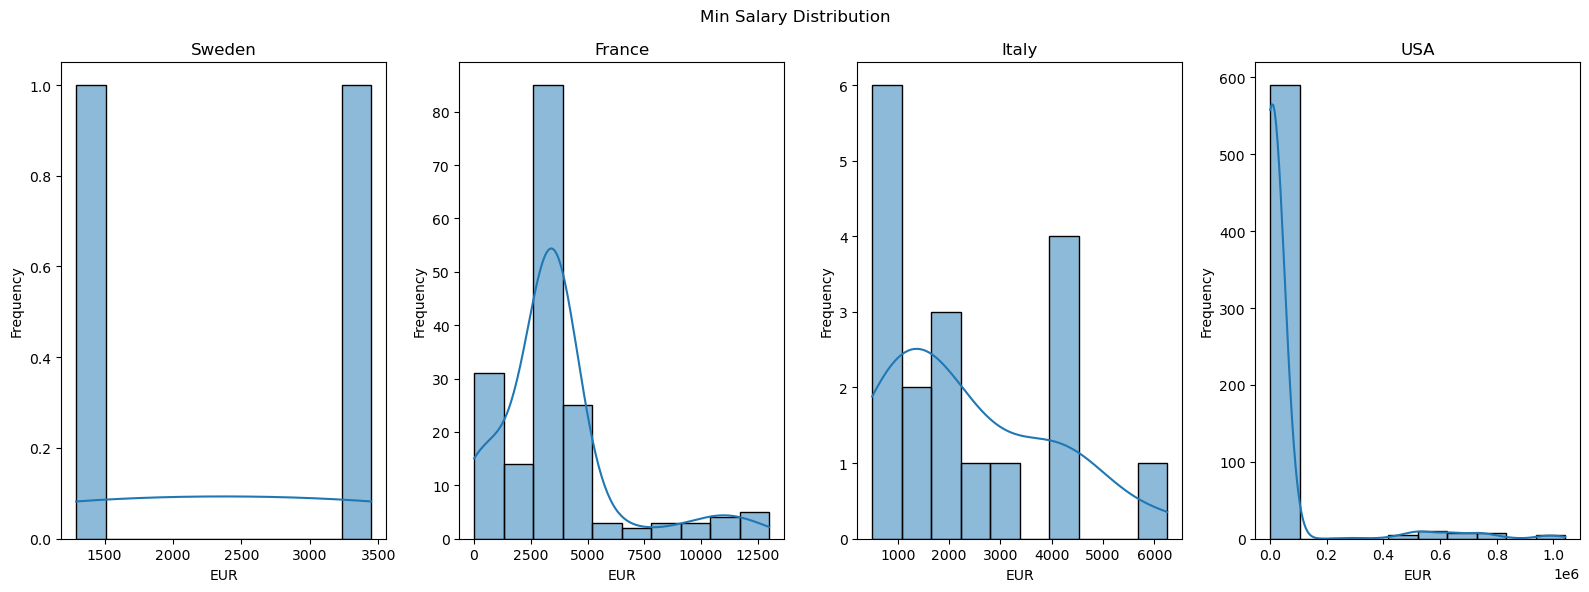

In [54]:
# Histograms for salaries
fig, axes = plt.subplots(1, len(df_combined['country'].unique()), figsize=(16, 6))

# Create a histogram for each country
for i, country in enumerate(df_combined['country'].unique()):
    country_data = df_combined[df_combined['country'] == country]
    sns.histplot(
        x='min_salary_month_EUR',
        data=country_data,
        bins=10,
        kde=True,
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(country)
    axes[i].set_xlabel('EUR')
    axes[i].set_ylabel('Frequency')

# Add a suptitle for the entire figure
plt.suptitle('Min Salary Distribution')
plt.tight_layout()

# Show the plot
plt.show()

Observations regarding salaries: 
- **Sweden**: has only two data points. This makes sense cause in Swedish interview processes you usually do not discuss salaries until the very end of the rounds. Range:  
- **France**: peaks at ..... Has errors in it. Some really low values are months instead of salaries. Range: 
- **Italy**: peaks at 1500 EUR per month. Interesting strange second peak at 4000 EUR.  Range: very large?
- **USA**: significantly higher salaries overall, as to be expected. Tons of outliers? Need to look into mins and max values. Range: 

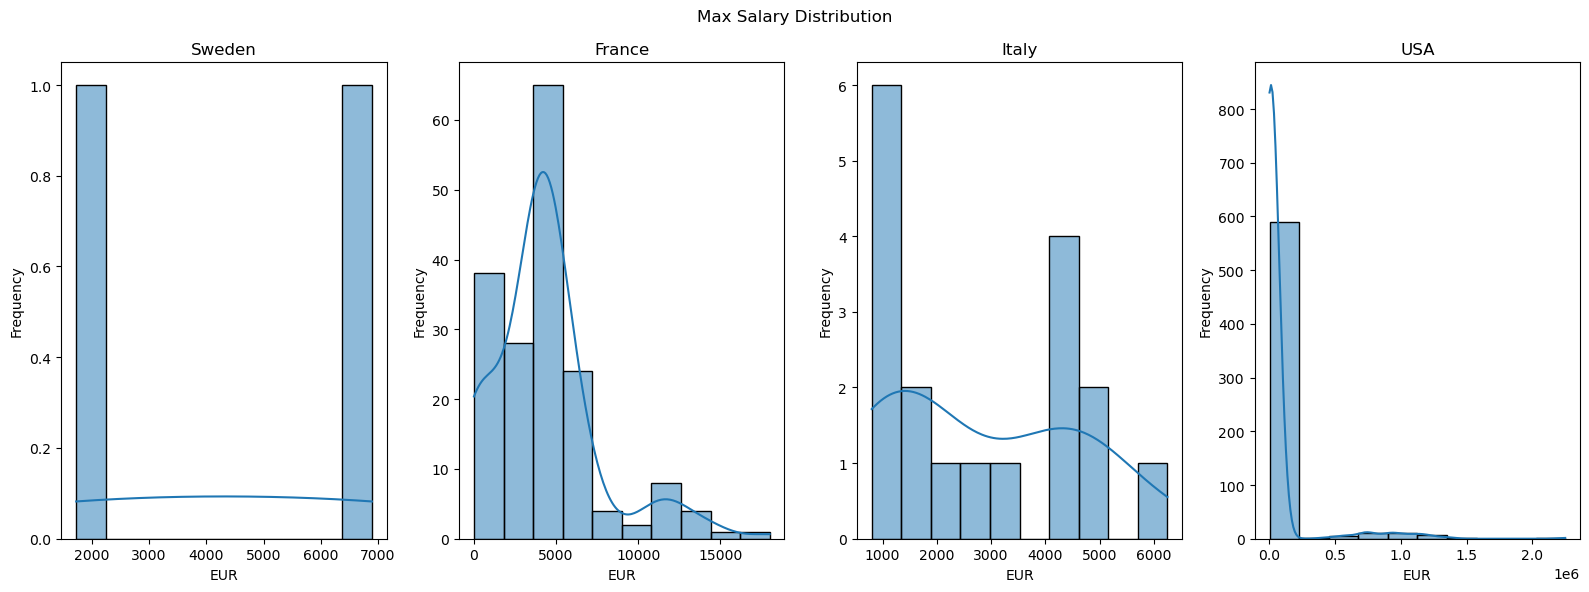

In [55]:
# Plot the maximum salaries too 
# Histograms for salaries
fig, axes = plt.subplots(1, len(df_combined['country'].unique()), figsize=(16, 6))

# Create a histogram for each country
for i, country in enumerate(df_combined['country'].unique()):
    country_data = df_combined[df_combined['country'] == country]
    sns.histplot(
        x='max_salary_month_EUR',
        data=country_data,
        bins=10,
        kde=True,
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(country)
    axes[i].set_xlabel('EUR')
    axes[i].set_ylabel('Frequency')

# Add a suptitle for the entire figure
plt.suptitle('Max Salary Distribution')
plt.tight_layout()

# Show the plot
plt.show()

Peaks might suggest there are differences for different job titles? Lets check this. 

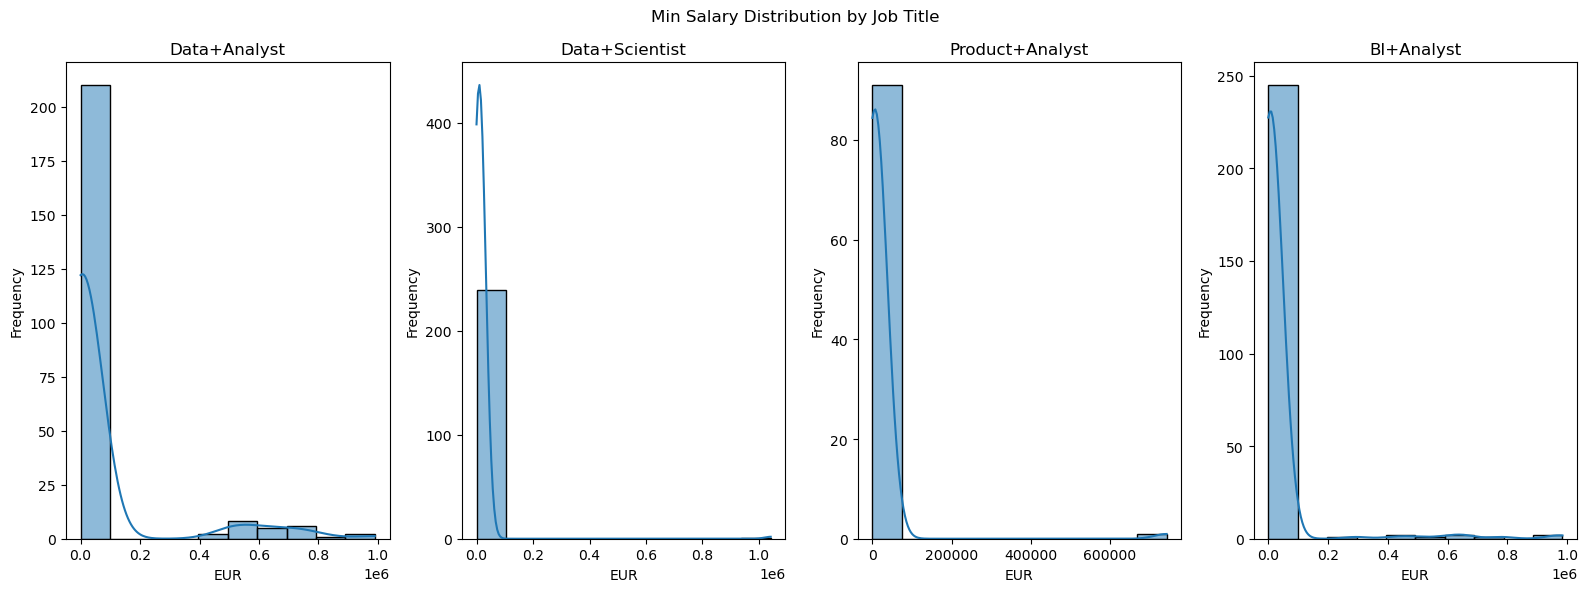

In [56]:
# Histograms for salaries by job title
fig, axes = plt.subplots(1, len(df_combined['search_keyword'].unique()), figsize=(16, 6))

# Create a histogram for each job title
for i, job_title in enumerate(df_combined['search_keyword'].unique()):
    job_title_data = df_combined[df_combined['search_keyword'] == job_title]
    sns.histplot(
        x='min_salary_month_EUR',
        data=job_title_data,
        bins=10,
        kde=True,
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(job_title)
    axes[i].set_xlabel('EUR')
    axes[i].set_ylabel('Frequency')

# Add a suptitle for the entire figure
plt.suptitle('Min Salary Distribution by Job Title')
plt.tight_layout()

# Show the plot
plt.show()

It might be interesting to look into the job listings that are particularly well paid. What are their characteristics? 

In [57]:
df_combined.describe() # Check that min and max values make sense 

min_index = df_combined['min_salary_month_EUR'].idxmin()
row_with_min = df_combined.loc[df_combined['min_salary_month_EUR'].idxmin()]
#row_with_min['salary']
# seems like extraction of salary is not checking for what says after the number 
# there is also a max value of 3 that is messed up for France 

Summary statistics for min_salary_month_EUR:
count    6.250000e+02
mean     4.569484e+04
std      1.562834e+05
min      1.708920e+03
25%      6.408450e+03
50%      8.702833e+03
75%      1.186750e+04
max      1.041454e+06
Name: min_salary_month_EUR, dtype: float64




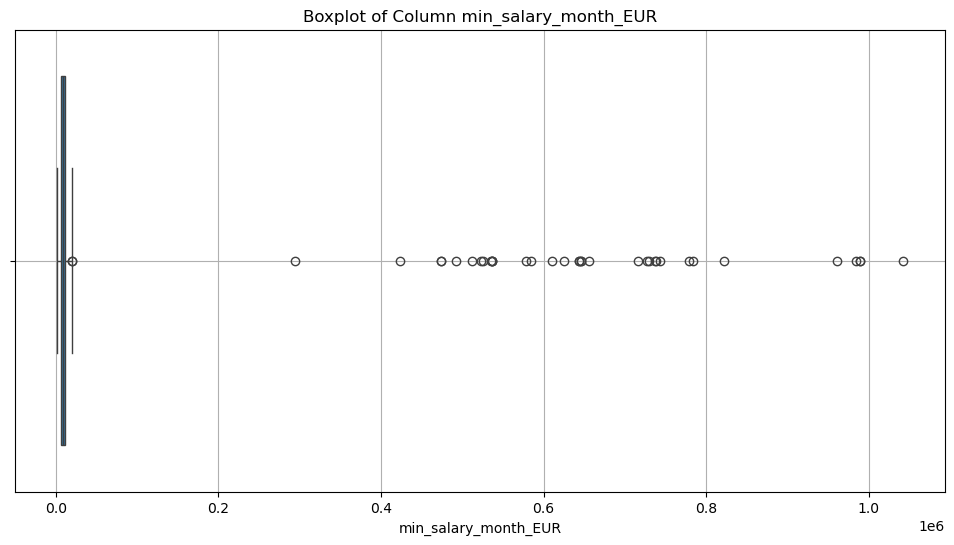

Summary statistics for max_salary_month_EUR:
count    6.250000e+02
mean     6.490108e+04
std      2.260980e+05
min      1.708920e+03
25%      9.327855e+03
50%      1.250043e+04
75%      1.760346e+04
max      2.249129e+06
Name: max_salary_month_EUR, dtype: float64




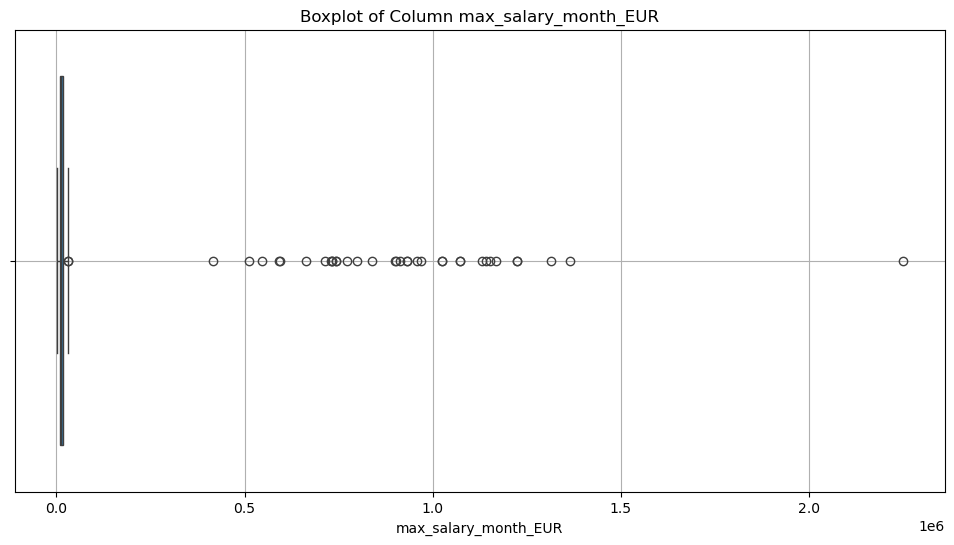

In [58]:
country_mask = (df_combined['country'] == 'USA')
country = df_combined[country_mask]
numerical_columns = ['min_salary_month_EUR', 'max_salary_month_EUR']  # Replace with your actual numerical columns
mf.plot_numerical(country, numerical_columns)


In [59]:
# Dont forget the new table keyword_counts_combined 

## Bivariate analysis 

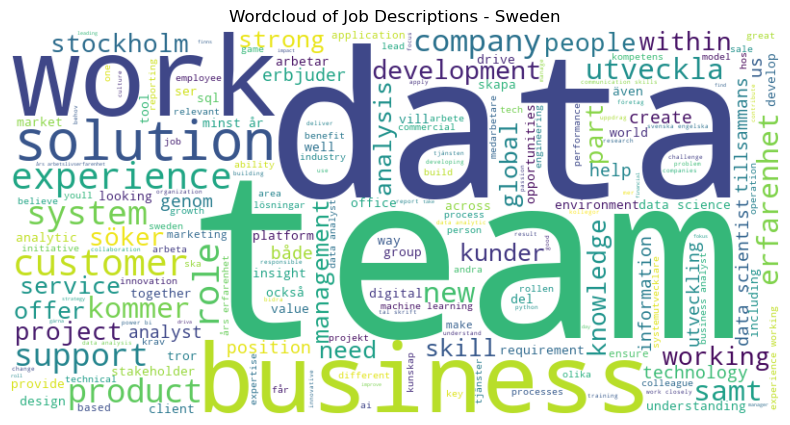

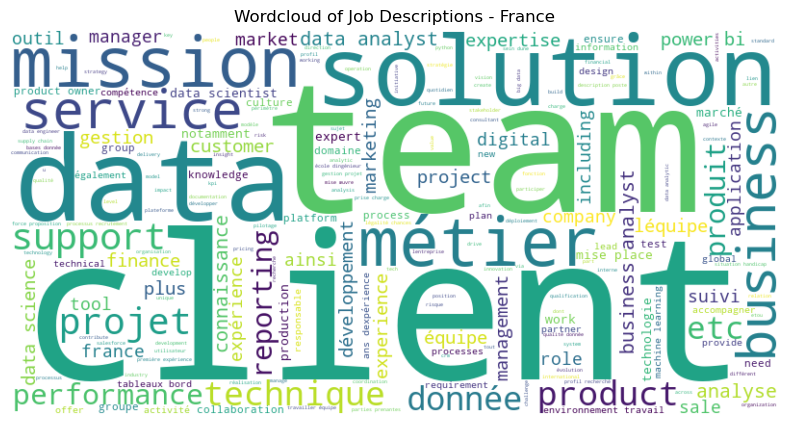

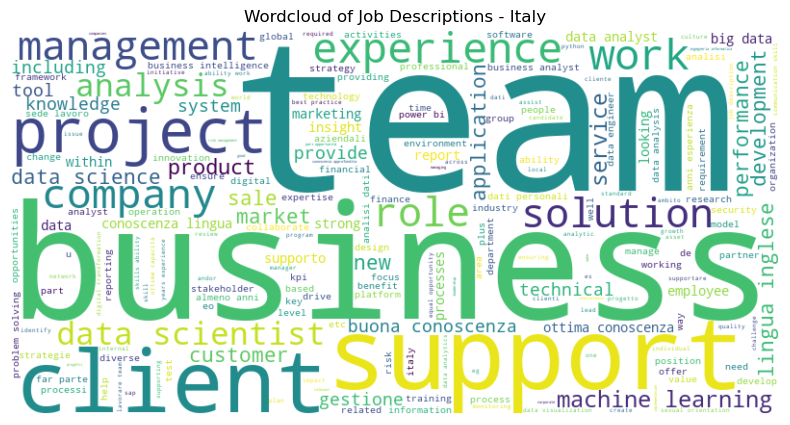

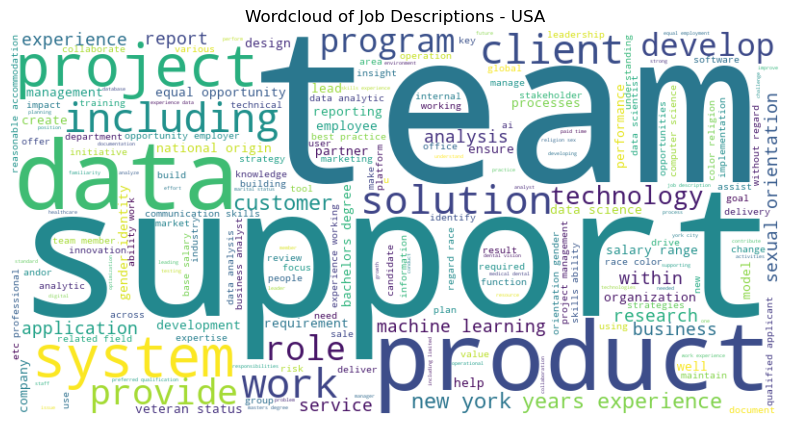

In [60]:
# Word cloud visualizations per country
def plt_wordtree(data, country):
    #df = data['job_description']
    #country = 'France'
    # Combine all the text into a single string 
    text = ' '.join(data)
    # Create a wordcloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    # Display the wordcloud 
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Wordcloud of Job Descriptions - {country}')
    plt.axis('off')
    plt.show()

plt_wordtree(common_keywords_SWE[1], 'Sweden')
plt_wordtree(common_keywords_FRA[1], 'France')
plt_wordtree(common_keywords_ITA[1], 'Italy')
plt_wordtree(common_keywords_USA[1], 'USA')

In [61]:
# Add also word cloud visualizations per job title? 

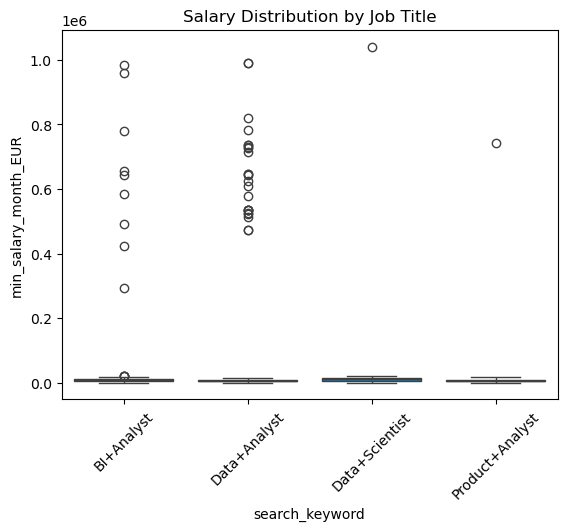

/var/folders/gn/8nkn38bx2sx8bsc75s35k5fm0000gn/T/ipykernel_15767/2601955150.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_salary = df_combined.groupby('search_keyword')['min_salary_month_EUR'].mean().reset_index()


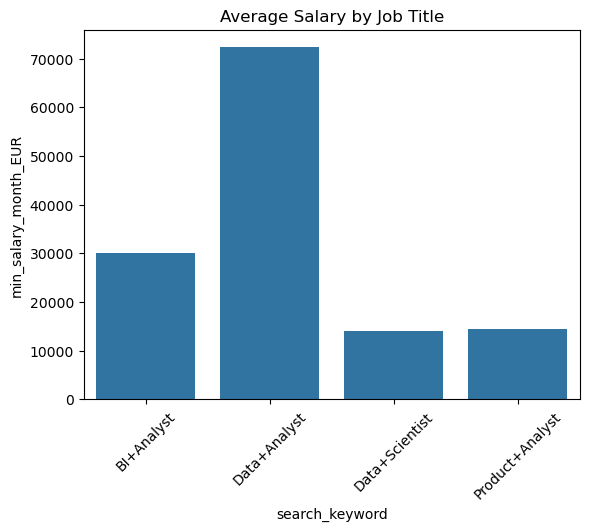

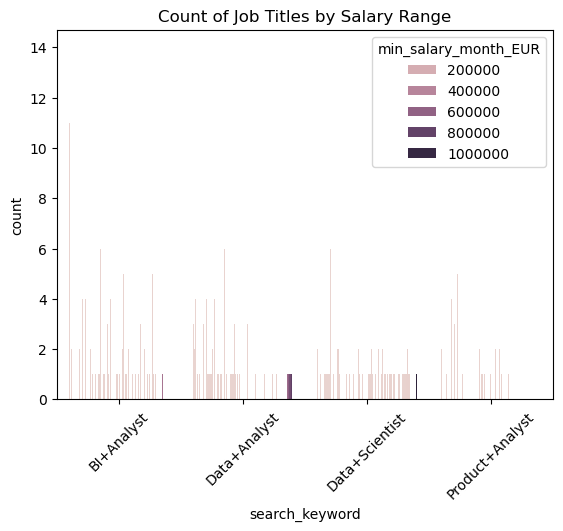

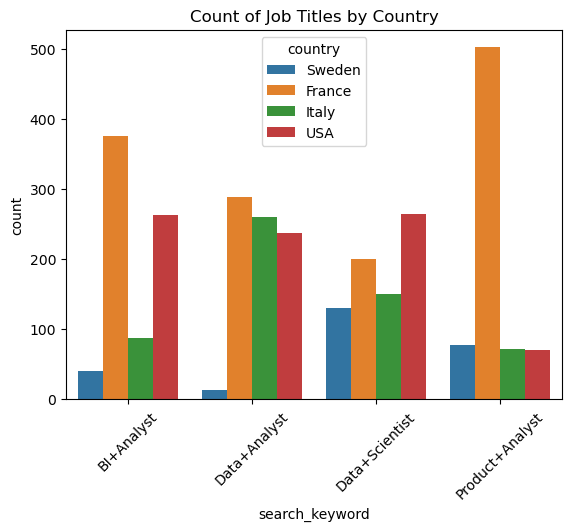

In [62]:
# Number of job listings per job title and country 
# Box plots help visualize the distribution of salary ranges across different categories (e.g., job titles, countries).
# Look at outliers in the box plot! 

sns.boxplot(data=df_combined, x='search_keyword', y='min_salary_month_EUR')
plt.xticks(rotation=45)
plt.title('Salary Distribution by Job Title')
plt.show()

mean_salary = df_combined.groupby('search_keyword')['min_salary_month_EUR'].mean().reset_index()
sns.barplot(data=mean_salary, x='search_keyword', y='min_salary_month_EUR')
plt.xticks(rotation=45)
plt.title('Average Salary by Job Title')
plt.show()

sns.countplot(data=df_combined, x='search_keyword', hue='min_salary_month_EUR')
plt.xticks(rotation=45)
plt.title('Count of Job Titles by Salary Range')
plt.show()

sns.countplot(data=df_combined, x='search_keyword', hue='country')
plt.xticks(rotation=45)
plt.title('Count of Job Titles by Country')
plt.show()

There are a bunch of data analyst (also data scientist) jobs that are very well paid. Do they have anything in common? 

In [63]:
import scipy.stats as stats
salary_ranges = pd.cut(df_combined['salary_num_low'], bins=[0, 20000, 40000, 60000, 80000, 100000], labels=['<20k', '20-40k', '40-60k', '60-80k', '80-100k'])
crosstab = pd.crosstab(df_combined['search_keyword'], salary_ranges)
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
print(f'Chi-squared: {chi2}, p-value: {p}')

Chi-squared: 39.48834036396891, p-value: 8.740764936169583e-05


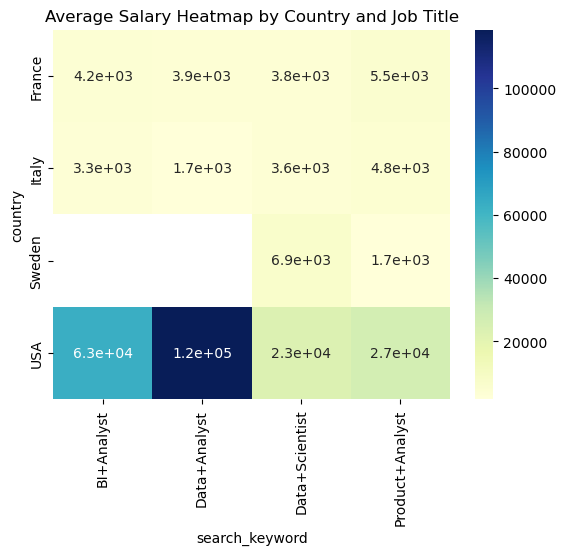

In [64]:
pivot_table = df_combined.pivot_table(values='max_salary_month_EUR', index='country', columns='search_keyword', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Average Salary Heatmap by Country and Job Title')
plt.show()

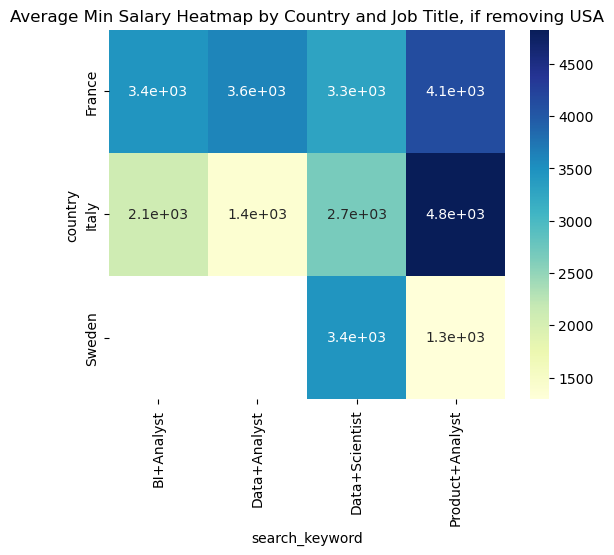

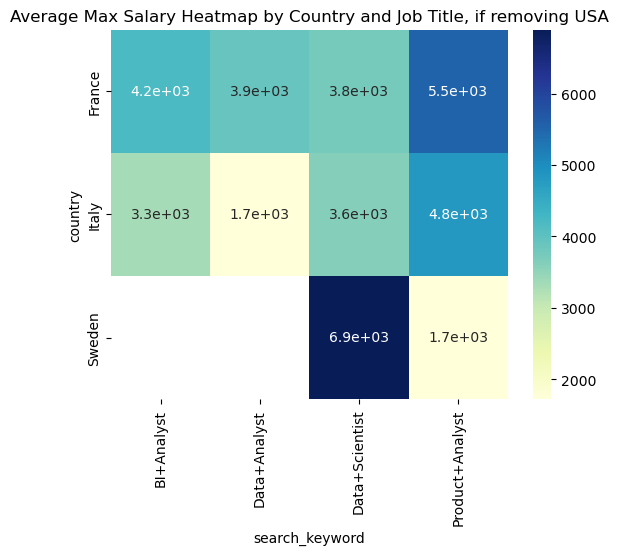

In [65]:
# What if you remove USA? 
non_usa_mask = df_combined['country'] != 'USA'

# Create the pivot table using the non-USA rows
pivot_table_min = df_combined.loc[non_usa_mask].pivot_table(values='min_salary_month_EUR', index='country', columns='search_keyword', aggfunc='mean')
pivot_table_max = df_combined.loc[non_usa_mask].pivot_table(values='max_salary_month_EUR', index='country', columns='search_keyword', aggfunc='mean')

sns.heatmap(pivot_table_min, annot=True, cmap='YlGnBu')
plt.title('Average Min Salary Heatmap by Country and Job Title, if removing USA')
plt.show()

sns.heatmap(pivot_table_max, annot=True, cmap='YlGnBu')
plt.title('Average Max Salary Heatmap by Country and Job Title, if removing USA')
plt.show()

## Conclusions 
TBA.

Where did the analysis of programming languages etc. go?

Salaries: 
- As expected, salaries are significantly higher in the US. For some reason, maximum salaries appear to be for Data Analyst jobs? 
- If you want to be well paid in Europe, it seems like a good idea to become a Data Scientist in Sweden, or Product Analyst in France or Italy. There are tons of jobs that fell under the 'Product Analyst' title for France. Have to look into this. It would be worth looking into the job descriptions of these titles in France and Italy to understand this better. There are too few data points for Sweden. 

- Job titles appear to vary somewhat between countries (since top 3 ones were different for different countries). 
- Clean up job titles for different countries?
- Case studies 